# Extração das áreas das imagens anotadas como cancerígenas

Este scrip divide as imagens em pedáços de dimenções específicadas e salva as que são consideradas como imagens contendo regiões cancerígenas.

In [3]:
# Nesccery libraries

# mask binarization
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

# image ROI split
import os
import sys
import shutil
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps

## Mask Binarization

In [18]:
# imagem
img_path = r"C:\Users\IA\Pictures\Datasets\GasHis\cancer_Sub_Ori_test1\2017-06-10_11.20.11.ndpi.17.56932_12520.2048x2048.png"
# annotated image mask
mask_path = r"C:\Users\IA\Pictures\Datasets\GasHis\cancer_Sub_Ori_test1\2017-06-10_11.20.11.ndpi.17.56932_12520.2048x2048_mask.png"

In [19]:
# load and change image to RGB
img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# load and change mask type
color_mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
color_mask = color_mask.astype("uint8")

In [4]:
# take only red mask chanel
red_mask = color_mask[:,:,2]
# mask binarization 
_, mask = cv.threshold(red_mask, 0, 255, cv.THRESH_BINARY_INV)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

True

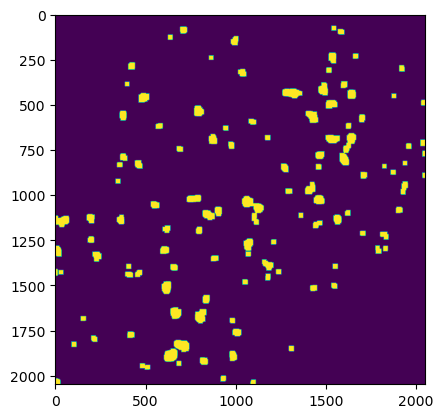

In [20]:
# define the kernel
kernel = np.ones((5, 5), np.uint8)
 
# erode the image
erosion_mask = cv.erode(color_mask, kernel, iterations=3)    
    
# dilate the image
dilation_mask = cv.dilate(erosion_mask, kernel, iterations=6)
plt.imshow(dilation_mask)

# show and save binirazed mask
plt.imshow(dilation_mask)
dst_path = mask_path[:-4] + "_bin.png"
cv.imwrite(dst_path, dilation_mask)

## [Extracting ROI](https://towardsdatascience.com/images-and-masks-splitting-into-multiple-pieces-in-python-with-google-colab-2f6b2ddcb322)

In [4]:
# create a new directory and delete the contents of an existing one
def dir_create(path):
    if (os.path.exists(path)) and (os.listdir(path) != []):
        shutil.rmtree(path)
        os.makedirs(path)
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# recorta uma área específica de uma imagem
def crop(input_file, height, width):
    print(input_file)
    img = Image.open(input_file)
    img_width, img_height = img.size
    for i in range(img_height//height):
        for j in range(img_width//width):
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield img.crop(box)

In [19]:
def split(inp_img_dir, inp_msk_dir, out_dir, height, width, start_num):
    
    image_dir = os.path.join(out_dir, 'images')
    mask_dir = os.path.join(out_dir, 'masks')
    
    # create directories
    dir_create(out_dir)
    dir_create(image_dir)
    dir_create(mask_dir)
    
    img_list = [f for f in
                os.listdir(inp_img_dir)
                if os.path.isfile(os.path.join(inp_img_dir, f))]
    
    file_num = 0
    
    for infile in img_list:
        # list of the images that are considered non tumors
        non_tumor_list = []
        
        # mask name
        infile_path = os.path.join(inp_msk_dir, infile[:-4] + '_mask.png')
        
        for k, piece in enumerate(crop(infile_path, height, width), start_num):
            
            msk = Image.new('RGB', (height, width), 255)
            msk.paste(piece)
            msk = ImageOps.grayscale(msk)
            msk_path = os.path.join(mask_dir, infile.split('.')[0] + '_' + str(k).zfill(5) + '.png')
            
            # check if the mask correspond to a tumor piece
            # take the number of white pixels
            white_pixels = cv.countNonZero(np.asarray(msk))
            # percentage of white pixels
            wpxl_percent = (white_pixels / (width*height))*100
            if wpxl_percent > 20:
                msk.save(msk_path) 
            else:
                non_tumor_list.append(k) # create a list of non tumor images
              
        infile_path = os.path.join(inp_img_dir, infile)
       
        for k, piece in enumerate(crop(infile_path, height, width), start_num):
            # only save tumors image
            if k not in non_tumor_list:
                img = Image.new('RGB', (height, width), 255)
                img.paste(piece)
                img_path = os.path.join(image_dir, infile.split('.')[0] + '_' + str(k).zfill(5) + '.png')
                img.save(img_path)
        
        file_num += 1
        
        # save imag
        
        sys.stdout.write("\rFile %s was processed." % file_num)
        sys.stdout.write("\n")
        sys.stdout.flush()
        

In [20]:
inp_img_dir = r"C:\Users\IA\Documents\Python Scripts\Image to Split\images"
inp_msk_dir = r"C:\Users\IA\Documents\Python Scripts\Image to Split\masks" 
out_dir = r"C:\Users\IA\Documents\Python Scripts\Image to Split\patches"
height = 256
width = 256
start_num = 1

In [21]:
# list with image names
input_images_list = glob.glob(inp_img_dir + '/*.png')
# list with mask names
input_masks_list = glob.glob(inp_msk_dir + '/*.png')
# split images acording to region of interest
split(inp_img_dir, inp_msk_dir, out_dir, height, width, start_num)

C:\Users\IA\Documents\Python Scripts\Image to Split\masks\TCGA-BR-8291-01Z-00-DX1.a7e89a69-6d6d-4c43-b299-a618bd859170_0_16384_40960_mask.png
C:\Users\IA\Documents\Python Scripts\Image to Split\images\TCGA-BR-8291-01Z-00-DX1.a7e89a69-6d6d-4c43-b299-a618bd859170_0_16384_40960.png
File 1 was processed.
